# Agent testing
---

Here we provide code snippets to test an RL agent:
* its reward distribution
* its policy function
* timeseries for episodes controlled by it

## Setup

In [7]:
from rl4greencrab import greenCrabSimplifiedEnv as gcse
from rl4greencrab import simulator, get_simulator, evaluate_agent, multiConstAction

from plotnine import ggplot, aes, geom_line, geom_density, geom_point, geom_jitter, xlim
from sb3_contrib import TQC
from stable_baselines3 import PPO

import numpy as np
import pandas as pd

In [8]:
CONFIG = {
    'action_reward_scale': [0.08, 0.08, 0.4],
    'max_action': 3000,
    'trapm_pmax': 10 * 0.1 * 2.75e-5, #2.26e-6,
    'trapf_pmax': 10 * 0.03 * 2.75e-5, #8.3e-7,
    'traps_pmax': 10 * 2.75e-5, #2.75e-5,
    'action_reward_exponent': 10,
}

In [9]:
tqc1 = TQC.load('../saved_agents/TQC-gcsenv-1.zip', device='cpu')
# tqc2 = TQC.load('../saved_agents/TQC-gcsenv-1_4.zip', device='cpu')

In [10]:
optimal_ntraps = [1584.1933526641956, 1319.5875573778267, 1530.8775860138805]
optimal_action = [2 * ntraps / CONFIG['max_action'] - 1 for ntraps in optimal_ntraps]

constAct = multiConstAction(
    env=gcse(config=CONFIG), 
    action=np.array(optimal_action)
)

## Reward distribution

In [11]:
tqc1_rew = evaluate_agent(
    env=gcse(config=CONFIG), agent=tqc1, ray_remote=True
).evaluate(return_episode_rewards=True, n_eval_episodes=120)

# tqc2_rew = evaluate_agent(
#     env=gcse(config=CONFIG), agent=tqc2, ray_remote=True
# ).evaluate(return_episode_rewards=True, n_eval_episodes=120)

constAct_rew = evaluate_agent(
    env=gcse(config=CONFIG), agent=constAct, ray_remote=True
).evaluate(return_episode_rewards=True, n_eval_episodes=120)


2024-04-17 22:04:30,225	INFO worker.py:1752 -- Started a local Ray instance.


In [13]:
tqc1_df = pd.DataFrame(
    {
        'agent': ['tqc1' for _ in tqc1_rew],
        'rew': tqc1_rew
    }
)

# tqc2_df = pd.DataFrame(
#     {
#         'agent': ['tqc2' for _ in tqc2_rew],
#         'rew': tqc2_rew
#     }
# )

constAct_df = pd.DataFrame(
    {
        'agent': ['constAct' for _ in constAct_rew],
        'rew': constAct_rew
    }
)

combined_df = pd.concat([tqc1_df, constAct_df])
# combined_df = constAct_df

INFO: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


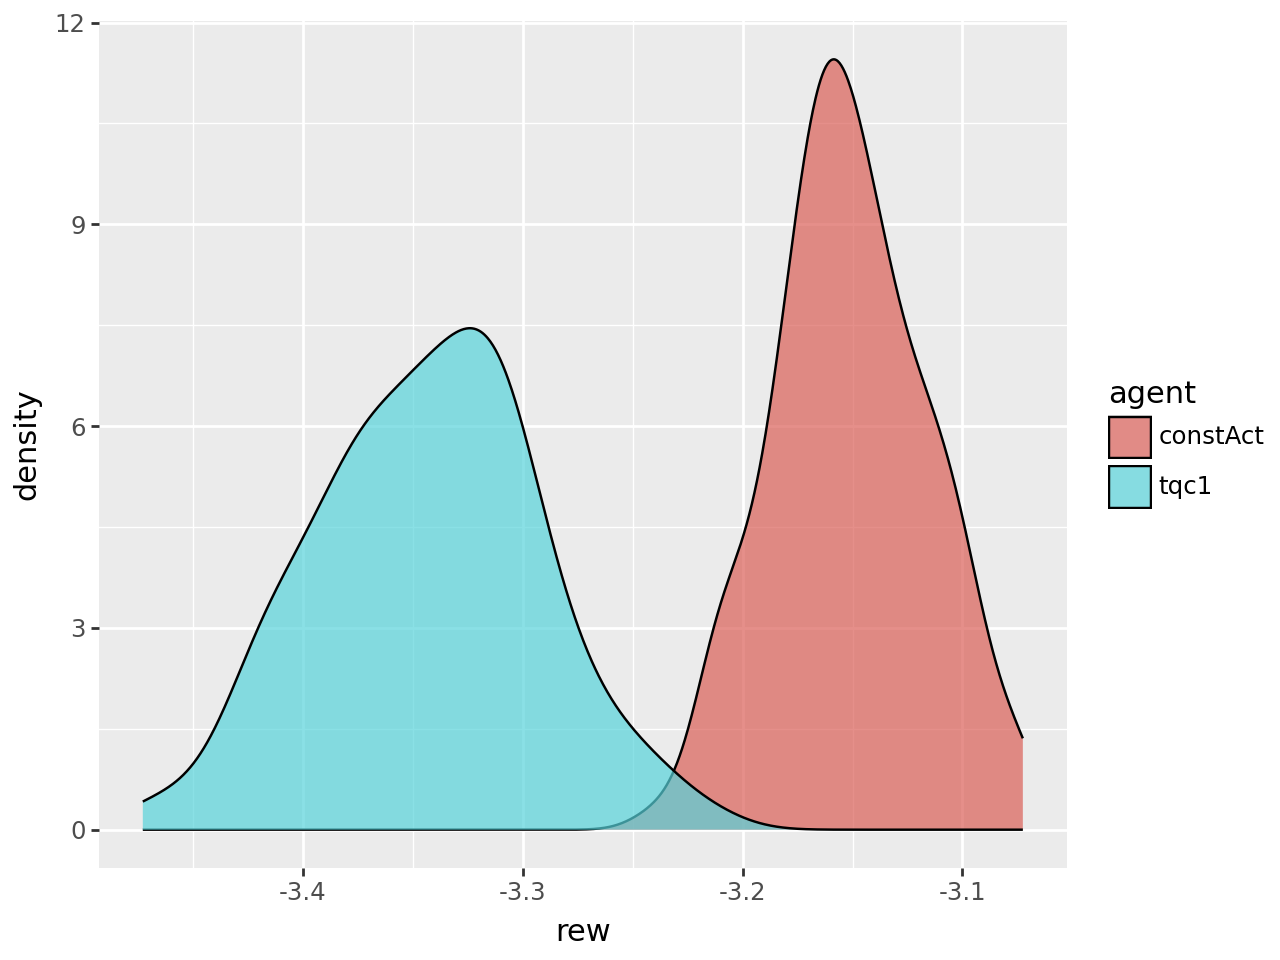

In [14]:
ggplot(combined_df, aes(x='rew', fill='agent')) + geom_density(alpha=0.7)
# ggplot(combined_df, aes(y='rew', x='agent')) + geom_point(alpha=0.7) + geom_jitter()

In [15]:
import ray
ray.shutdown() # to free up ram now that we dont need ray (used it inside of evaluate_agent)

## Policy function

In [16]:
env = gcse(config=CONFIG)

In [17]:
env.reset()

(array([-1., -1.], dtype=float32), {})

In [18]:
import ray

@ray.remote
def action_at_ij(i, j, agent):
    actions = []
    N_samples = 1000
    for _ in range(N_samples):
        # x,y,z = 2 * np.random.rand(3) - 1
        obs = np.float32([i, j])
        action, info = agent.predict(obs)
        actions.append(action)
    act0 = [action[0] for action in actions]
    act1 = [action[1] for action in actions]
    act2 = [action[2] for action in actions]

    mean_act0 = np.mean(act0)
    std_act0 = np.std(act0)

    mean_act1 = np.mean(act1)
    std_act1 = np.std(act1)

    mean_act2 = np.mean(act2)
    std_act2 = np.std(act2)
    
    return [mean_act0, mean_act1, mean_act2], [std_act0, std_act1, std_act2]



In [20]:
import itertools
n_points = 51

def indices():
    return itertools.product(np.linspace(-1,1,n_points), np.linspace(-1,1,n_points))


A = ray.get(
    [
        action_at_ij.remote(i,j, tqc1)
        for i, j in indices()
    ]
)

print('done generating A')

ray.shutdown()

print('ray shut down')

trap_strengths = np.array([CONFIG['trapm_pmax'], CONFIG['trapf_pmax'], CONFIG['traps_pmax']])

action_df = pd.DataFrame(
    {
        'i': [i for (i,j) in indices()],
        'j': [j for (i,j) in indices()],
        'avg_action': [
            (
                CONFIG['max_action'] * (np.array(a[0]) + 1)/2
            ).dot(trap_strengths) 
            for a in A
        ]
    }
)

print('done with action df')

del A

print('done deleting')

2024-04-17 22:05:57,935	INFO worker.py:1752 -- Started a local Ray instance.


done generating A
ray shut down
done with action df
done deleting


In [21]:
pivot_action_df = action_df.pivot(index='i', columns='j', values='avg_action')

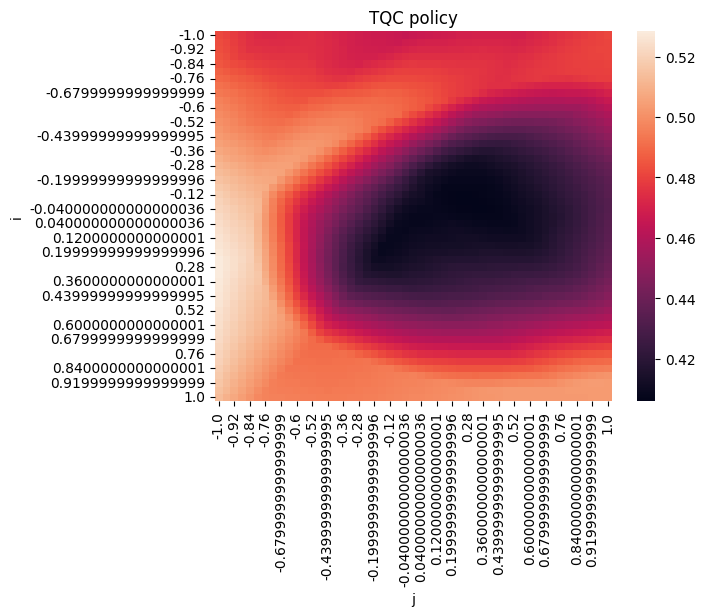

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(pivot_action_df)

ax.set_title("TQC policy")
plt.show()

In [23]:
np.array(optimal_ntraps).dot(trap_strengths)

0.4754432507004496